# Compas Analysis

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.

## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

Modified from original https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb?short_path=0bb3511

## Provided dataset

1. compas.db - SQLite database with complete data
2. compas-scores-two-years.csv - Filtered dataset for two-year recidivism analysis
3. compas-scores-two-years-violent.csv - Violent recidivism subset
4. compas-scores-raw.csv - Raw COMPAS scores

In [1]:
# dependencies
!pip install missingno
# !pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [81]:
# filter dplyr warnings
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.formula.api import glm
from datetime import datetime

warnings.filterwarnings('ignore')

# compas-scores-two-years.csv Investigation

In [3]:
# Read dataset
df = pd.read_csv("./datasets/compas-analysis/compas-scores-two-years.csv")
print(df.head())



   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45             Other  ...               1   

   v_score_text  v_screening_date  in_custody  out_custody  pr

In [4]:
print(df.describe())

                 id          age  juv_fel_count  decile_score  juv_misd_count  \
count   7214.000000  7214.000000    7214.000000   7214.000000     7214.000000   
mean    5501.255753    34.817993       0.067230      4.509565        0.090934   
std     3175.706870    11.888922       0.473972      2.856396        0.485239   
min        1.000000    18.000000       0.000000      1.000000        0.000000   
25%     2735.250000    25.000000       0.000000      2.000000        0.000000   
50%     5509.500000    31.000000       0.000000      4.000000        0.000000   
75%     8246.500000    42.000000       0.000000      7.000000        0.000000   
max    11001.000000    96.000000      20.000000     10.000000       13.000000   

       juv_other_count  priors_count  days_b_screening_arrest  \
count      7214.000000   7214.000000              6907.000000   
mean          0.109371      3.472415                 3.304763   
std           0.501586      4.882538                75.809505   
min       

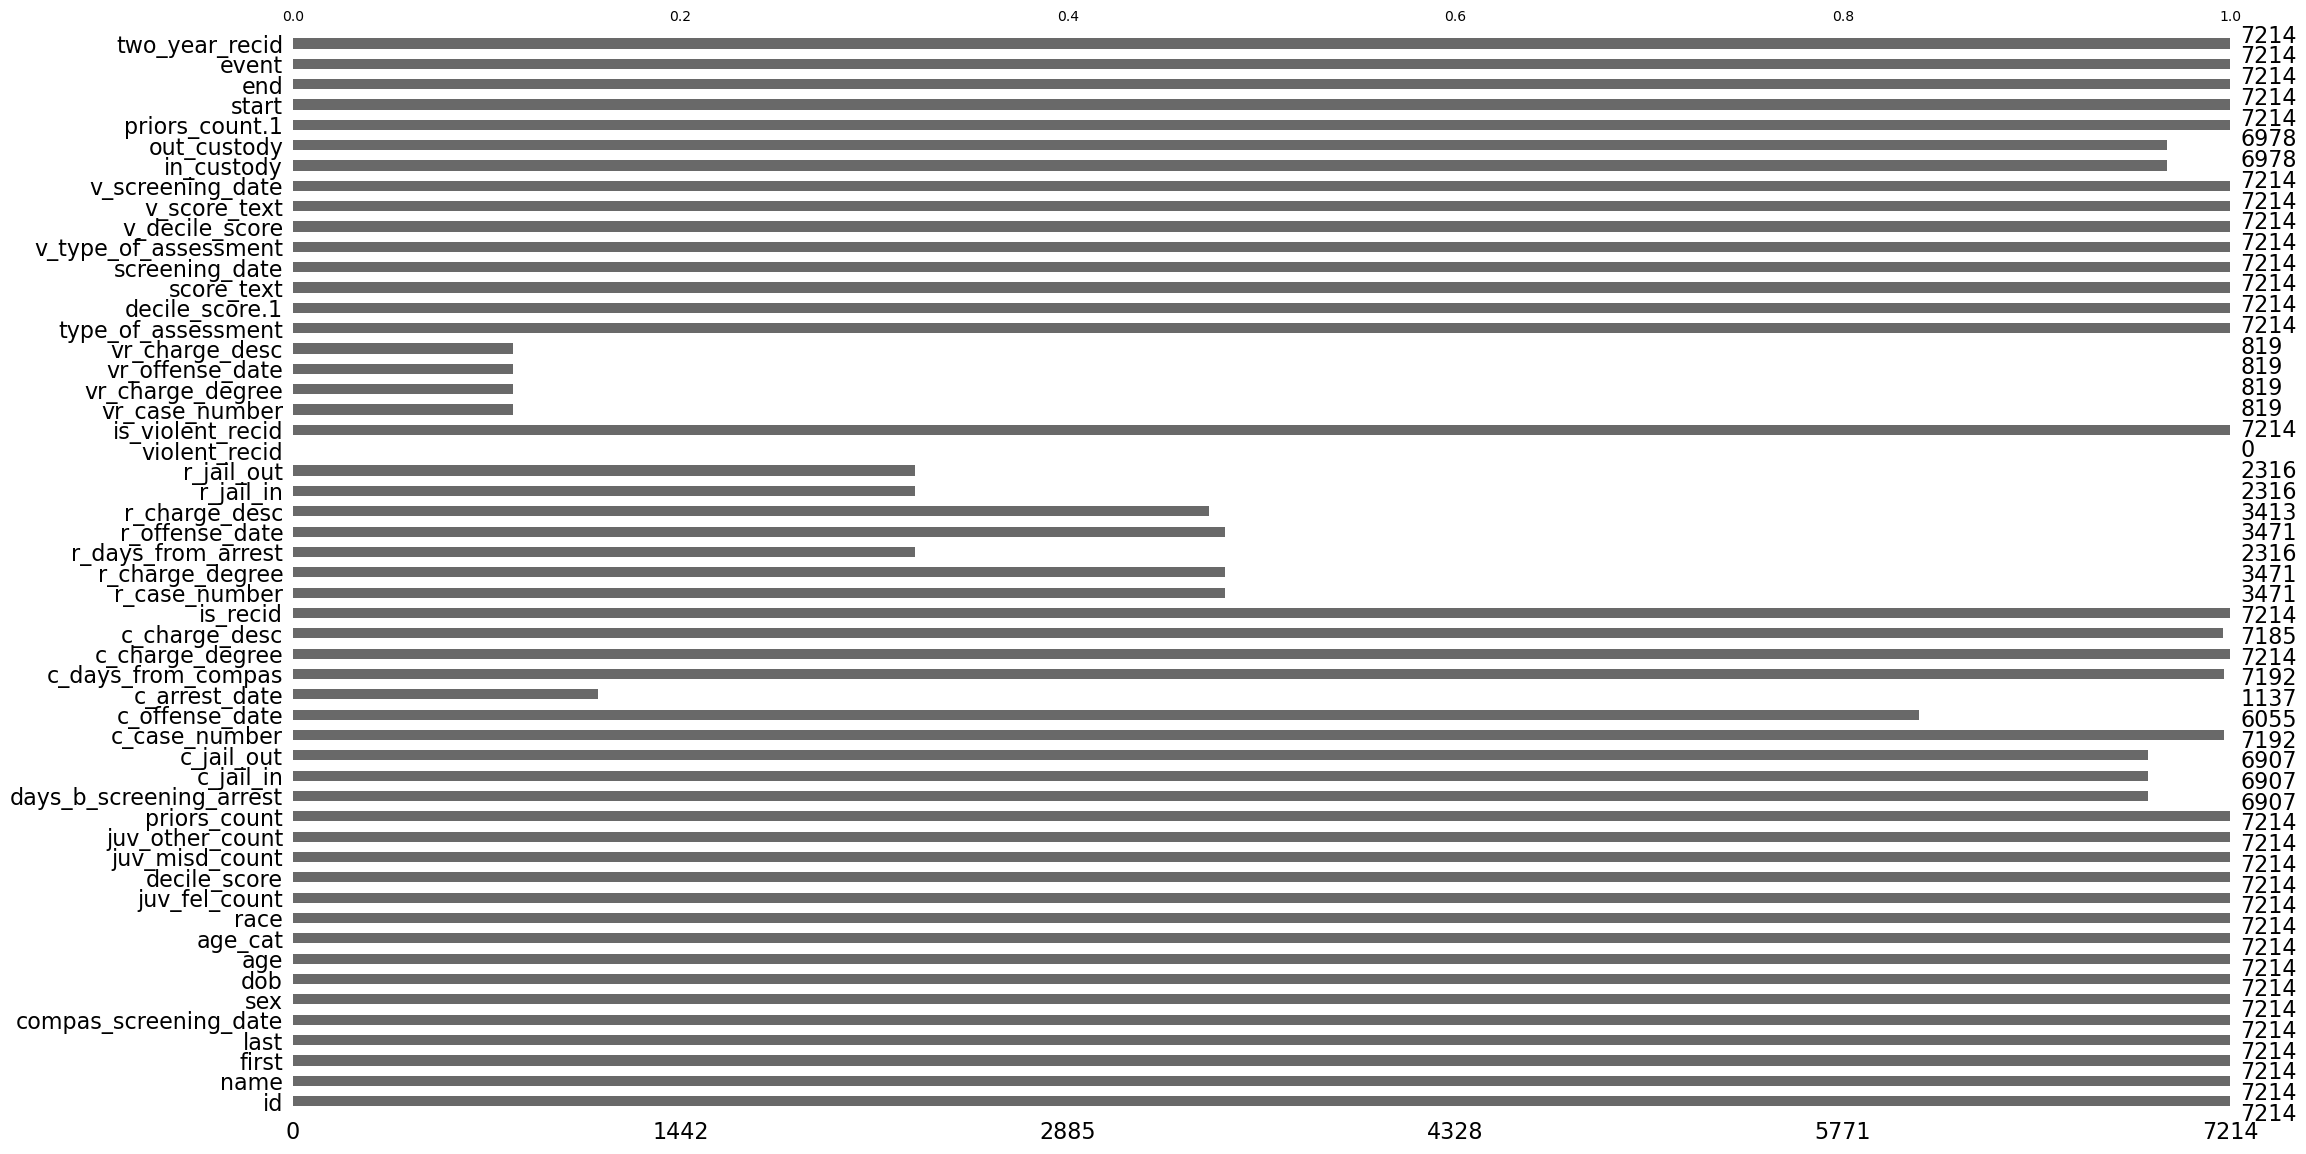

In [5]:
# Check missing data
# print(df.info()) 
# The fuller the bar graph --> more filled the data
import missingno as msno  
msno.bar(df)
plt.show()

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [6]:

cleaned_df = df[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]

# Charge Date Mismatch clean (±30 day window)
cleaned_df= cleaned_df[cleaned_df["days_b_screening_arrest"] <= 30 ]
cleaned_df= cleaned_df[ cleaned_df["days_b_screening_arrest"] >= -30]

# Missing COMPAS Cases 
cleaned_df = cleaned_df[cleaned_df["is_recid"]!= -1]

# Ordinary Traffic Offenses 
cleaned_df = cleaned_df[cleaned_df["c_charge_degree" ] != "O"]

# Missing score_text
cleaned_df = cleaned_df[cleaned_df["score_text"] != 'N/A']

# It is already the dataset of 2 years period so we dont need to filter it out
cleaned_df.head()


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


Higher COMPAS scores are slightly correlated with a longer length of stay. 

In [ ]:

# create new column length of stay
# subtract time to get the difference --> get the time stayed

print(type(cleaned_df["c_jail_in"][0]))
cleaned_df["c_jail_in"] = pd.to_datetime(cleaned_df["c_jail_in"])
cleaned_df["c_jail_out"] = pd.to_datetime(cleaned_df["c_jail_out"])
# cleaned_df["length_of_stay"] 

# Calculate length of stay
cleaned_df["length_of_stay"] = (cleaned_df["c_jail_out"] - cleaned_df["c_jail_in"]).dt.days

# Calculate correlation
correlation = cleaned_df["length_of_stay"].corr(cleaned_df["decile_score"])
print(f"Correlation: {correlation}")

cleaned_df.head()


<class 'str'>
Correlation: 0.2074780847803188


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,length_of_stay
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,0
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,10
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,1
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,6


After filtering we have the following demographic breakdown:

In [8]:
cleaned_df["age_cat"].value_counts()

age_cat
25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: count, dtype: int64

In [9]:
# African American take the most proportion in the dataset
cleaned_df["race"].value_counts()

race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64

In [10]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [11]:
cleaned_df["score_text"].value_counts()

score_text
Low       3421
Medium    1607
High      1144
Name: count, dtype: int64

In [12]:
race_sex_table = pd.crosstab(cleaned_df["race"], cleaned_df["sex"])
print(race_sex_table)

sex               Female  Male
race                          
African-American     549  2626
Asian                  2    29
Caucasian            482  1621
Hispanic              82   427
Native American        2     9
Other                 58   285


In [13]:
cleaned_df["sex"].value_counts()

sex
Male      4997
Female    1175
Name: count, dtype: int64

In [14]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


In [15]:
# total of two year recid prisioner

(cleaned_df[cleaned_df["two_year_recid"] == 1])["two_year_recid"].value_counts()

two_year_recid
1    2809
Name: count, dtype: int64

In [16]:
# %%R
# nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100

# count of people are true to two_year_recid to all
print((cleaned_df[cleaned_df["two_year_recid"] == 1])["two_year_recid"].value_counts())

# total count
print(cleaned_df["two_year_recid"].value_counts())

# In total 83% of those people did have two year recid 
print(2809/3363 * 100)

two_year_recid
1    2809
Name: count, dtype: int64
two_year_recid
0    3363
1    2809
Name: count, dtype: int64
83.52661314302706


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

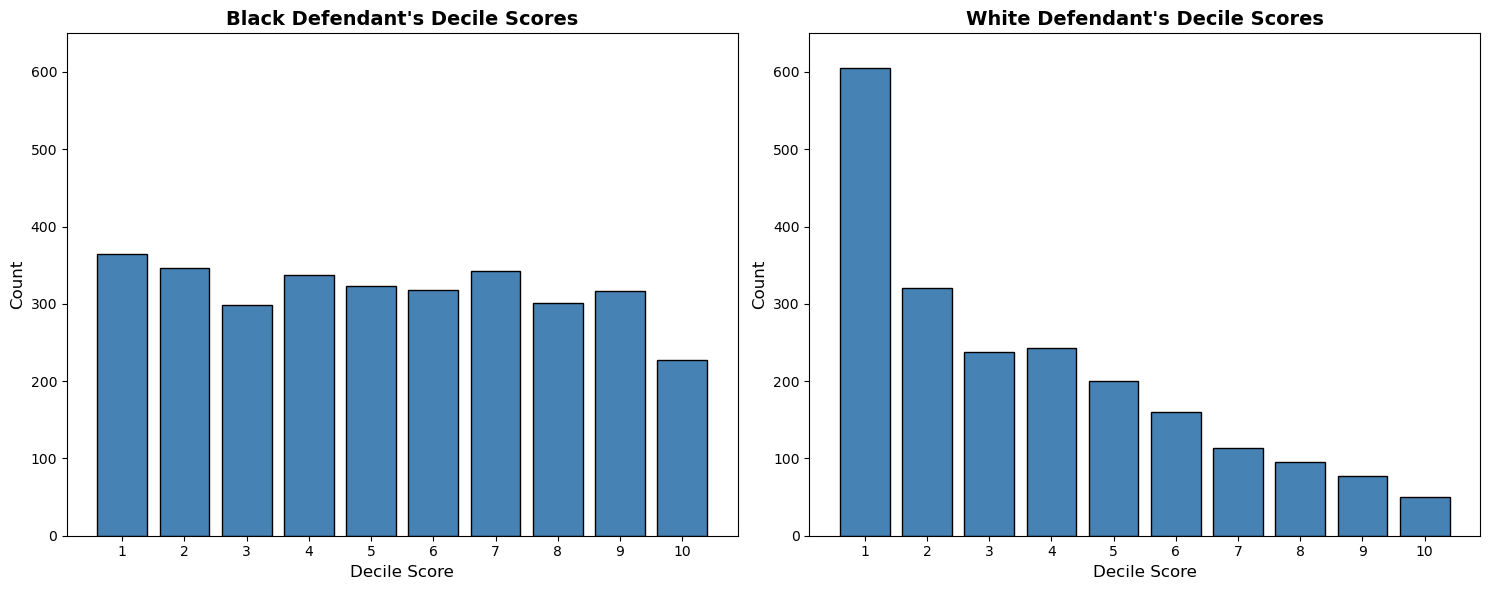

In [17]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Black defendants
black_df = cleaned_df[cleaned_df["race"] == "African-American"]
black_counts = black_df["decile_score"].value_counts().sort_index()
ax1.bar(black_counts.index, black_counts.values, color='steelblue', edgecolor='black')
ax1.set_xlabel("Decile Score", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)
ax1.set_ylim(0, 650)
ax1.set_title("Black Defendant's Decile Scores", fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, 11))

# White defendants
white_df = cleaned_df[cleaned_df["race"] == "Caucasian"]
white_counts = white_df["decile_score"].value_counts().sort_index()
ax2.bar(white_counts.index, white_counts.values, color='steelblue', edgecolor='black')
ax2.set_xlabel("Decile Score", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_ylim(0, 650)
ax2.set_title("White Defendant's Decile Scores", fontsize=14, fontweight='bold')
ax2.set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

In [18]:

decile_score_race_table = pd.crosstab(cleaned_df["decile_score"], cleaned_df["race"])
print(decile_score_race_table)

race          African-American  Asian  Caucasian  Hispanic  Native American  \
decile_score                                                                  
1                          365     15        605       159                0   
2                          346      4        321        89                2   
3                          298      5        238        73                1   
4                          337      0        243        47                0   
5                          323      1        200        39                0   
6                          318      2        160        27                2   
7                          343      1        113        28                2   
8                          301      2         96        14                0   
9                          317      0         77        17                2   
10                         227      1         50        16                2   

race          Other  
decile_score         
1      

In [19]:
# # Multivariate Analysis
# plt.figure(figsize=(15, 10))

# sns.heatmap(cleaned_df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

# plt.title('Correlation Heatmap')
# plt.show()

## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [74]:
cleaned_df.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,length_of_stay
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,0
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,10
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,1
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,6


In [ ]:


# Create factor variables (categorical encodings)
df_model = cleaned_df.copy()
# Convert to categorical and set reference levels
df_model['crime_factor'] = pd.Categorical(df_model['c_charge_degree'])

df_model['age_factor'] = pd.Categorical(df_model['age_cat'])
# Reorder categories to make category at index 0 the reference
age_categories = df_model['age_factor'].cat.categories.tolist()
df_model['age_factor'] = df_model['age_factor'].cat.reorder_categories(
    [age_categories[0]] + [cat for cat in age_categories if cat != age_categories[0]]
)

df_model['race_factor'] = pd.Categorical(df_model['race'])
# Set the 3rd category (index 2) as reference
race_categories = df_model['race_factor'].cat.categories.tolist()
df_model['race_factor'] = df_model['race_factor'].cat.reorder_categories(
    [race_categories[2]] + [cat for cat in race_categories if cat != race_categories[2]]
)

df_model['gender_factor'] = pd.Categorical(df_model['sex'], 
                                            categories=['Male', 'Female'])
# Set 'Male' as reference
df_model.head()

df_model['gender_factor'] = df_model['gender_factor'].cat.reorder_categories(['Male', 'Female'])

df_model['score_factor'] = (df_model['score_text'] != 'Low').map({False: 'LowScore', True: 'HighScore'})
df_model['score_factor'] = pd.Categorical(df_model['score_factor'])


# put in glm model
model = glm(formula='score_factor ~ gender_factor + age_factor + race_factor + priors_count + crime_factor + two_year_recid',
                data=df_model, 
                family=sm.families.Binomial())

result = model.fit()
print(result.summary())


                                   Generalized Linear Model Regression Results                                   
Dep. Variable:     ['score_factor[HighScore]', 'score_factor[LowScore]']   No. Observations:                 6172
Model:                                                               GLM   Df Residuals:                     6160
Model Family:                                                   Binomial   Df Model:                           11
Link Function:                                                     Logit   Scale:                          1.0000
Method:                                                             IRLS   Log-Likelihood:                -3084.2
Date:                                                   Thu, 05 Feb 2026   Deviance:                       6168.4
Time:                                                           01:21:21   Pearson chi2:                 6.07e+03
No. Iterations:                                                        6   Pseudo R-squ.

Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [82]:
control = np.exp(-1.52554) / (1 + np.exp(-1.52554))
result = np.exp(0.47721) / (1 - control + (control * np.exp(0.47721)))

print(f"Control: {control}")
print(f"Result: {result}")

Control: 0.17864717443340628
Result: 1.4528408658138932


Women are 19.4% more likely than men to get a higher score.

In [83]:
result = np.exp(0.22127) / (1 - control + (control * np.exp(0.22127)))
result

1.1947978508506671

Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [ ]:
np.exp(1.30839) / (1 - control + (control * np.exp(1.30839)))

2.4961202077189455

### Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [85]:
# %%R
# raw_data <- read.csv("./compas-scores-two-years-violent.csv")
# nrow(raw_data)


# Read dataset
df_vi = pd.read_csv("./datasets/compas-analysis/compas-scores-two-years-violent.csv")
print(df_vi.head())



   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   5         marcu brown   marcu        brown            2013-01-13  Male   
3   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   
4   7        marsha miles  marsha        miles            2013-11-30  Male   

          dob  age          age_cat              race  ...  v_score_text  \
0  1947-04-18   69  Greater than 45             Other  ...           Low   
1  1982-01-22   34          25 - 45  African-American  ...           Low   
2  1993-01-21   23     Less than 25  African-American  ...        Medium   
3  1973-01-22   43          25 - 45             Other  ...           Low   
4  1971-08-22   44          25 - 45             Other  ...           Low   

   v_screening_date  in_custody  out_custody  priors_count.1  start   end 

In [86]:
# %%R
# df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, v_score_text, sex, priors_count, 
#                     days_b_screening_arrest, v_decile_score, is_recid, two_year_recid) %>% 
#         filter(days_b_screening_arrest <= 30) %>%
#         filter(days_b_screening_arrest >= -30) %>% 
#         filter(is_recid != -1) %>%
#         filter(c_charge_degree != "O") %>%
#         filter(v_score_text != 'N/A')
# nrow(df)


cleaned_df_vi = df_vi[["age", "c_charge_degree", "race", "age_cat", "v_score_text", "sex", "priors_count", "days_b_screening_arrest", "v_decile_score", "is_recid", "two_year_recid"]]

# Charge Date Mismatch clean (±30 day window)
cleaned_df_vi= cleaned_df_vi[cleaned_df_vi["days_b_screening_arrest"] <= 30 ]
cleaned_df_vi= cleaned_df_vi[ cleaned_df_vi["days_b_screening_arrest"] >= -30]

# Missing COMPAS Cases 
cleaned_df_vi = cleaned_df_vi[cleaned_df_vi["is_recid"]!= -1]

# Ordinary Traffic Offenses 
cleaned_df_vi = cleaned_df_vi[cleaned_df_vi["c_charge_degree" ] != "O"]

# Missing score_text
cleaned_df_vi = cleaned_df_vi[cleaned_df_vi["v_score_text"] != 'N/A']

cleaned_df_vi.head()

,age,c_charge_degree,race,age_cat,v_score_text,sex,priors_count,days_b_screening_arrest,v_decile_score,is_recid,two_year_recid
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,1,1,1
4,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0
5,43,F,Other,25 - 45,Low,Male,3,-1.0,3,0,0
6,39,M,Caucasian,25 - 45,Low,Female,0,-1.0,1,0,0


In [90]:
# %%R
# summary(df$age_cat)
cleaned_df_vi["age_cat"].value_counts()

age_cat
25 - 45            2300
Greater than 45     954
Less than 25        766
Name: count, dtype: int64

In [91]:
# %%R
# summary(df$race)
cleaned_df_vi["race"].value_counts()

race
African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: count, dtype: int64

In [92]:
# %%R
# summary(df$v_score_text)
cleaned_df_vi["v_score_text"].value_counts()

v_score_text
Low       2913
Medium     828
High       279
Name: count, dtype: int64

In [29]:
# %%R
# nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100

In [30]:
# %%R
# nrow(filter(df, two_year_recid == 1))

In [31]:
# %%R -w 900 -h 363 -u px
# library(grid)
# library(gridExtra)
# pblack <- ggplot(data=filter(df, race =="African-American"), aes(ordered(v_decile_score))) + 
#           geom_bar() + xlab("Violent Decile Score") +
#           ylim(0, 700) + ggtitle("Black Defendant's Violent Decile Scores")
# pwhite <- ggplot(data=filter(df, race =="Caucasian"), aes(ordered(v_decile_score))) + 
#           geom_bar() + xlab("Violent Decile Score") +
#           ylim(0, 700) + ggtitle("White Defendant's Violent Decile Scores")
# grid.arrange(pblack, pwhite,  ncol = 2)

In [32]:
# %%R
# df <- mutate(df, crime_factor = factor(c_charge_degree)) %>%
#       mutate(age_factor = as.factor(age_cat)) %>%
#       within(age_factor <- relevel(age_factor, ref = 1)) %>%
#       mutate(race_factor = factor(race,
#                                   labels = c("African-American", 
#                                              "Asian",
#                                              "Caucasian", 
#                                              "Hispanic", 
#                                              "Native American",
#                                              "Other"))) %>%
#       within(race_factor <- relevel(race_factor, ref = 3)) %>%
#       mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
#       within(gender_factor <- relevel(gender_factor, ref = 2)) %>%
#       mutate(score_factor = factor(v_score_text != "Low", labels = c("LowScore","HighScore")))
# model <- glm(score_factor ~ gender_factor + age_factor + race_factor +
#                             priors_count + crime_factor + two_year_recid, family="binomial", data=df)
# summary(model)

The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants.

In [33]:
# %%R
# control <- exp(-2.24274) / (1 + exp(-2.24274))
# exp(0.65893) / (1 - control + (control * exp(0.65893)))

Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.

In [34]:
# %%R
# exp(3.14591) / (1 - control + (control * exp(3.14591)))

## Predictive Accuracy of COMPAS

In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium or High risk,  we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in their [validation study](http://cjb.sagepub.com/content/36/1/21.abstract).

We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.

In [35]:
# %%R
# library(survival)
# library(ggfortify)

# data <- filter(filter(read.csv("./cox-parsed.csv"), score_text != "N/A"), end > start) %>%
#         mutate(race_factor = factor(race,
#                                   labels = c("African-American", 
#                                              "Asian",
#                                              "Caucasian", 
#                                              "Hispanic", 
#                                              "Native American",
#                                              "Other"))) %>%
#         within(race_factor <- relevel(race_factor, ref = 3)) %>%
#         mutate(score_factor = factor(score_text)) %>%
#         within(score_factor <- relevel(score_factor, ref=2))

# grp <- data[!duplicated(data$id),]
# nrow(grp)

In [36]:
# %%R
# summary(grp$score_factor)

In [37]:
# %%R
# summary(grp$race_factor)

In [38]:
# %%R
# f <- Surv(start, end, event, type="counting") ~ score_factor
# model <- coxph(f, data=data)
# summary(model)

People placed in the High category are 3.5 times as likely to recidivate, and the COMPAS system's concordance 63.6%. This is lower than the accuracy quoted in the Northpoint study of 68%.

In [39]:
# %%R
# decile_f <- Surv(start, end, event, type="counting") ~ decile_score
# dmodel <- coxph(decile_f, data=data)
# summary(dmodel)

COMPAS's decile scores are a bit more accurate at 66%.

We can test if the algorithm is behaving differently across races by including a race interaction term in the cox model.

In [40]:
# %%R
# f2 <- Surv(start, end, event, type="counting") ~ race_factor + score_factor + race_factor * score_factor
# model <- coxph(f2, data=data)
# print(summary(model))

The interaction term shows a similar disparity as the logistic regression above.

High risk white defendants are 3.61 more likely than low risk white defendants, while High risk black defendants are 2.99 more likely than low.

In [41]:
# import math
# print("Black High Hazard: %.2f" % (math.exp(-0.18976 + 1.28350)))
# print("White High Hazard: %.2f" % (math.exp(1.28350)))
# print("Black Medium Hazard: %.2f" % (math.exp(0.84286-0.17261)))
# print("White Medium Hazard: %.2f" % (math.exp(0.84286)))

In [42]:
# %%R -w 900 -h 563 -u px

# fit <- survfit(f, data=data)

# plotty <- function(fit, title) {
#   return(autoplot(fit, conf.int=T, censor=F) + ggtitle(title) + ylim(0,1))
# }
# plotty(fit, "Overall")

Black defendants do recidivate at higher rates according to race specific Kaplan Meier plots.

In [43]:
# %%R -w 900 -h 363 -u px
# white <- filter(data, race == "Caucasian")
# white_fit <- survfit(f, data=white)

# black <- filter(data, race == "African-American")
# black_fit <- survfit(f, data=black)

# grid.arrange(plotty(white_fit, "White defendants"), 
#              plotty(black_fit, "Black defendants"), ncol=2)

In [44]:
# %%R
# summary(fit, times=c(730))

In [45]:
# %%R
# summary(black_fit, times=c(730))

In [46]:
# %%R
# summary(white_fit, times=c(730))

Race specific models have similar concordance values.

In [47]:
# %%R
# summary(coxph(f, data=white))

In [48]:
# %%R
# summary(coxph(f, data=black))

Compas's violent recidivism score has a slightly higher overall concordance score of 65.1%.

In [49]:
# %%R
# violent_data <- filter(filter(read.csv("./cox-violent-parsed.csv"), score_text != "N/A"), end > start) %>%
#         mutate(race_factor = factor(race,
#                                   labels = c("African-American", 
#                                              "Asian",
#                                              "Caucasian", 
#                                              "Hispanic", 
#                                              "Native American",
#                                              "Other"))) %>%
#         within(race_factor <- relevel(race_factor, ref = 3)) %>%
#         mutate(score_factor = factor(score_text)) %>%
#         within(score_factor <- relevel(score_factor, ref=2))


# vf <- Surv(start, end, event, type="counting") ~ score_factor
# vmodel <- coxph(vf, data=violent_data)
# vgrp <- violent_data[!duplicated(violent_data$id),]
# print(nrow(vgrp))
# summary(vmodel)

In this case, there isn't a significant coefficient on African American's with High Scores.

In [50]:
# %%R
# vf2 <- Surv(start, end, event, type="counting") ~ race_factor + race_factor * score_factor
# vmodel <- coxph(vf2, data=violent_data)
# summary(vmodel)

In [51]:
# %%R
# summary(coxph(vf, data=filter(violent_data, race == "African-American")))

In [52]:
# %%R
# summary(coxph(vf, data=filter(violent_data, race == "Caucasian")))

In [53]:
# %%R -w 900 -h 363 -u px
# white <- filter(violent_data, race == "Caucasian")
# white_fit <- survfit(vf, data=white)

# black <- filter(violent_data, race == "African-American")
# black_fit <- survfit(vf, data=black)

# grid.arrange(plotty(white_fit, "White defendants"), 
#              plotty(black_fit, "Black defendants"), ncol=2)

## Directions of the Racial Bias

The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.

In [54]:
# from truth_tables import PeekyReader, Person, table, is_race, count, vtable, hightable, vhightable
# from csv import DictReader

# people = []
# with open("./cox-parsed.csv") as f:
#     reader = PeekyReader(DictReader(f))
#     try:
#         while True:
#             p = Person(reader)
#             if p.valid:
#                 people.append(p)
#     except StopIteration:
#         pass

# pop = list(filter(lambda i: ((i.recidivist == True and i.lifetime <= 730) or
#                               i.lifetime > 730), list(filter(lambda x: x.score_valid, people))))
# recid = list(filter(lambda i: i.recidivist == True and i.lifetime <= 730, pop))
# rset = set(recid)
# surv = [i for i in pop if i not in rset]

In [55]:
# print("All defendants")
# table(list(recid), list(surv))

In [56]:
# print("Total pop: %i" % (2681 + 1282 + 1216 + 2035))

In [57]:
# import statistics
# print("Average followup time %.2f (sd %.2f)" % (statistics.mean(map(lambda i: i.lifetime, pop)),
#                                                 statistics.stdev(map(lambda i: i.lifetime, pop))))
# print("Median followup time %i" % (statistics.median(map(lambda i: i.lifetime, pop))))

Overall, the false positive rate is 32.35%.

In [58]:
# print("Black defendants")
# is_afam = is_race("African-American")
# table(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

That number is higher for African Americans at 44.85%.

In [59]:
# print("White defendants")
# is_white = is_race("Caucasian")
# table(list(filter(is_white, recid)), list(filter(is_white, surv)))

And lower for whites at 23.45%.

In [60]:
# 44.85 / 23.45

Which means under COMPAS black defendants are 91% more likely to get a higher score and not go on to commit more crimes than white defendants after two year.

COMPAS scores misclassify white reoffenders as low risk at 70.4% more often than black reoffenders.

In [61]:
# 47.72 / 27.99

In [62]:
# hightable(list(filter(is_white, recid)), list(filter(is_white, surv)))

In [63]:
# hightable(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

## Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score.

In [64]:
# vpeople = []
# with open("./cox-violent-parsed.csv") as f:
#     reader = PeekyReader(DictReader(f))
#     try:
#         while True:
#             p = Person(reader)
#             if p.valid:
#                 vpeople.append(p)
#     except StopIteration:
#         pass

# vpop = list(filter(lambda i: ((i.violent_recidivist == True and i.lifetime <= 730) or
#                               i.lifetime > 730), list(filter(lambda x: x.vscore_valid, vpeople))))
# vrecid = list(filter(lambda i: i.violent_recidivist == True and i.lifetime <= 730, vpeople))
# vrset = set(vrecid)
# vsurv = [i for i in vpop if i not in vrset]

In [65]:
# print("All defendants")
# vtable(list(vrecid), list(vsurv))

Even moreso for Black defendants.

In [66]:
# print("Black defendants")
# is_afam = is_race("African-American")
# vtable(list(filter(is_afam, vrecid)), list(filter(is_afam, vsurv)))

In [67]:
# print("White defendants")
# is_white = is_race("Caucasian")
# vtable(list(filter(is_white, vrecid)), list(filter(is_white, vsurv)))

Black defendants are twice as likely to be false positives for a Higher violent score than white defendants.

In [68]:
# 38.14 / 18.46

White defendants are 63% more likely to get a lower score and commit another crime than Black defendants.

In [69]:
# 62.62 / 38.37

## Gender differences in Compas scores

In terms of underlying recidivism rates, we can look at gender specific Kaplan Meier estimates. There is a striking difference between women and men.

In [70]:
# %%R

# female <- filter(data, sex == "Female")
# male   <- filter(data, sex == "Male")
# male_fit <- survfit(f, data=male)
# female_fit <- survfit(f, data=female)

In [71]:
# %%R
# summary(male_fit, times=c(730))

In [72]:
# %%R
# summary(female_fit, times=c(730))

In [73]:
# %%R -w 900 -h 363 -u px
# grid.arrange(plotty(female_fit, "Female"), plotty(male_fit, "Male"),ncol=2)

As these plots show, the Compas score treats a High risk women the same as a Medium risk man.